# San Diego Burrito Analytics: Linear models

Scott Cole

21 May 2016

This notebook attempts to predict the overall rating of a burrito as a linear combination of its dimensions. Interpretation of these models is complicated by the significant correlations between dimensions (such as meat quality and non-meat filling quality).

### Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

import seaborn as sns
sns.set_style("white")

C:\Users\Scott\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load data

In [2]:
filename="burrito_current.csv"
df = pd.read_csv(filename)
N = df.shape[0]

# Linear model 1: Predict overall rating from the individual dimensions

In [3]:
# Define predictors of the model
m_lm = ['Hunger','Cost','Tortilla','Temp','Meat','Fillings','Meat:filling',
               'Uniformity','Salsa','Wrap']

# Remove incomplete data 
dffull = df[np.hstack((m_lm,'overall'))].dropna()
X = sm.add_constant(dffull[m_lm])
y = dffull['overall']
my_glm = sm.GLM(y,X)
res = my_glm.fit()
print(res.summary())
print 1 - np.var(res.resid_pearson) / np.var(y)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                overall   No. Observations:                   89
Model:                            GLM   Df Residuals:                       78
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                  0.152583346326
Method:                          IRLS   Log-Likelihood:                -36.753
Date:                Sat, 21 May 2016   Deviance:                       11.902
Time:                        16:24:54   Pearson chi2:                     11.9
No. Iterations:                     4                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -0.1148      0.431     -0.267      0.790        -0.959     0.729
Hunger           0.0156      0.051      0.309 

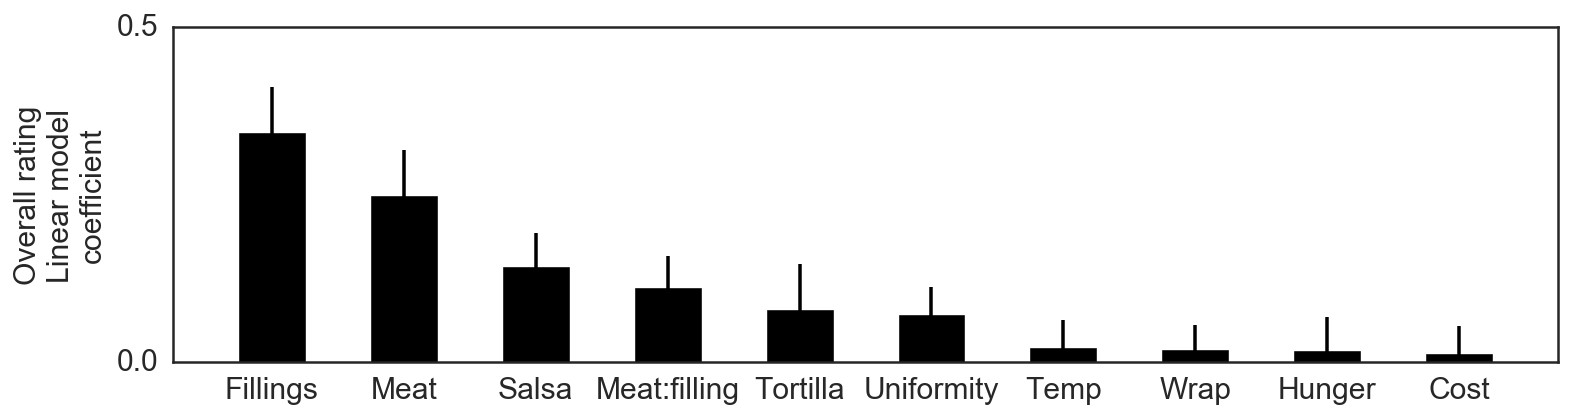

In [4]:
# Visualize coefficients
from tools.plt import bar
newidx = np.argsort(-res.params.values)
temp = np.arange(len(newidx))
newidx = np.delete(newidx,temp[newidx==0])
bar(res.params[newidx],res.bse[newidx],X.keys()[newidx],'Overall rating\nLinear model\ncoefficient',
    ylim =(0,.5),figsize=(11,3))
plt.plot()

figname = 'overall_metric_linearmodelcoef'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

# Linear model 2: predict overall rating from ingredients
This linear model is no better than generating random features, showing that simply a good choice of ingredients is not sufficient to making a high quality burrito.

In [5]:
# Get all ingredient keys
startingredients = 29
ingredientkeys = df.keys()[startingredients:]

# Get all ingredient keys with at least 10 burritos
Nlim = 10
ingredientkeys = ingredientkeys[df.count()[startingredients:].values>=Nlim]

# Make a dataframe for all ingredients
dfing = df[ingredientkeys]

# COnvert data to binary
for k in dfing.keys():
    dfing[k] = dfing[k].map({'x':1,'X':1,1:1})
    dfing[k] = dfing[k].fillna(0)
    

C:\Users\Scott\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Scott\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# Run a general linear model to predict overall burrito rating from ingredients
X = sm.add_constant(dfing)
y = df.overall
lm = sm.GLM(y,X)
res = lm.fit()
print(res.summary())
origR2 = 1 - np.var(res.resid_pearson) / np.var(y)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                overall   No. Observations:                  104
Model:                            GLM   Df Residuals:                       93
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                   0.56401902106
Method:                          IRLS   Log-Likelihood:                -111.98
Date:                Sat, 21 May 2016   Deviance:                       52.454
Time:                        16:24:55   Pearson chi2:                     52.5
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.5362      0.230     15.358      0.000         3.085     3.987
Beef          -0.0077      0.249     -0.031      0.9

In [7]:
# Test if the variance explained in this linear model is significantly better than chance
np.random.seed(0)
Nsurr = 1000
randr2 = np.zeros(Nsurr)
for n in range(Nsurr):
    Xrand = np.random.rand(X.shape[0],X.shape[1])
    Xrand[:,0] = np.ones(X.shape[0])
    lm = sm.GLM(y,Xrand)
    res = lm.fit()
    randr2[n] = 1 - np.var(res.resid_pearson) / np.var(y)
print 'p = ' , np.mean(randr2>origR2)

p =  0.268


# Linear model 3. Predicting Yelp ratings
Can also do this for Google ratings
Note, interestingly, that the Tortilla rating is most positively correlated with Yelp and Google ratings. This is significant in a linear model when accounting for the overall rating.

In [8]:
# Average each metric over each Location
# Avoid case issues; in the future should avoid article issues
df.Location = df.Location.str.lower()
m_Location = ['Location','N','Yelp','Google','Hunger','Cost','Volume','Tortilla','Temp','Meat','Fillings','Meat:filling',
               'Uniformity','Salsa','Synergy','Wrap','overall']

tacoshops = df.Location.unique()
TS = len(tacoshops)
dfmean = pd.DataFrame(np.nan, index=range(TS), columns=m_Location)
for ts in range(TS):
    dfmean.loc[ts] = df.loc[df.Location==tacoshops[ts]].mean()
    dfmean['N'][ts] = sum(df.Location == tacoshops[ts])
dfmean.Location = tacoshops

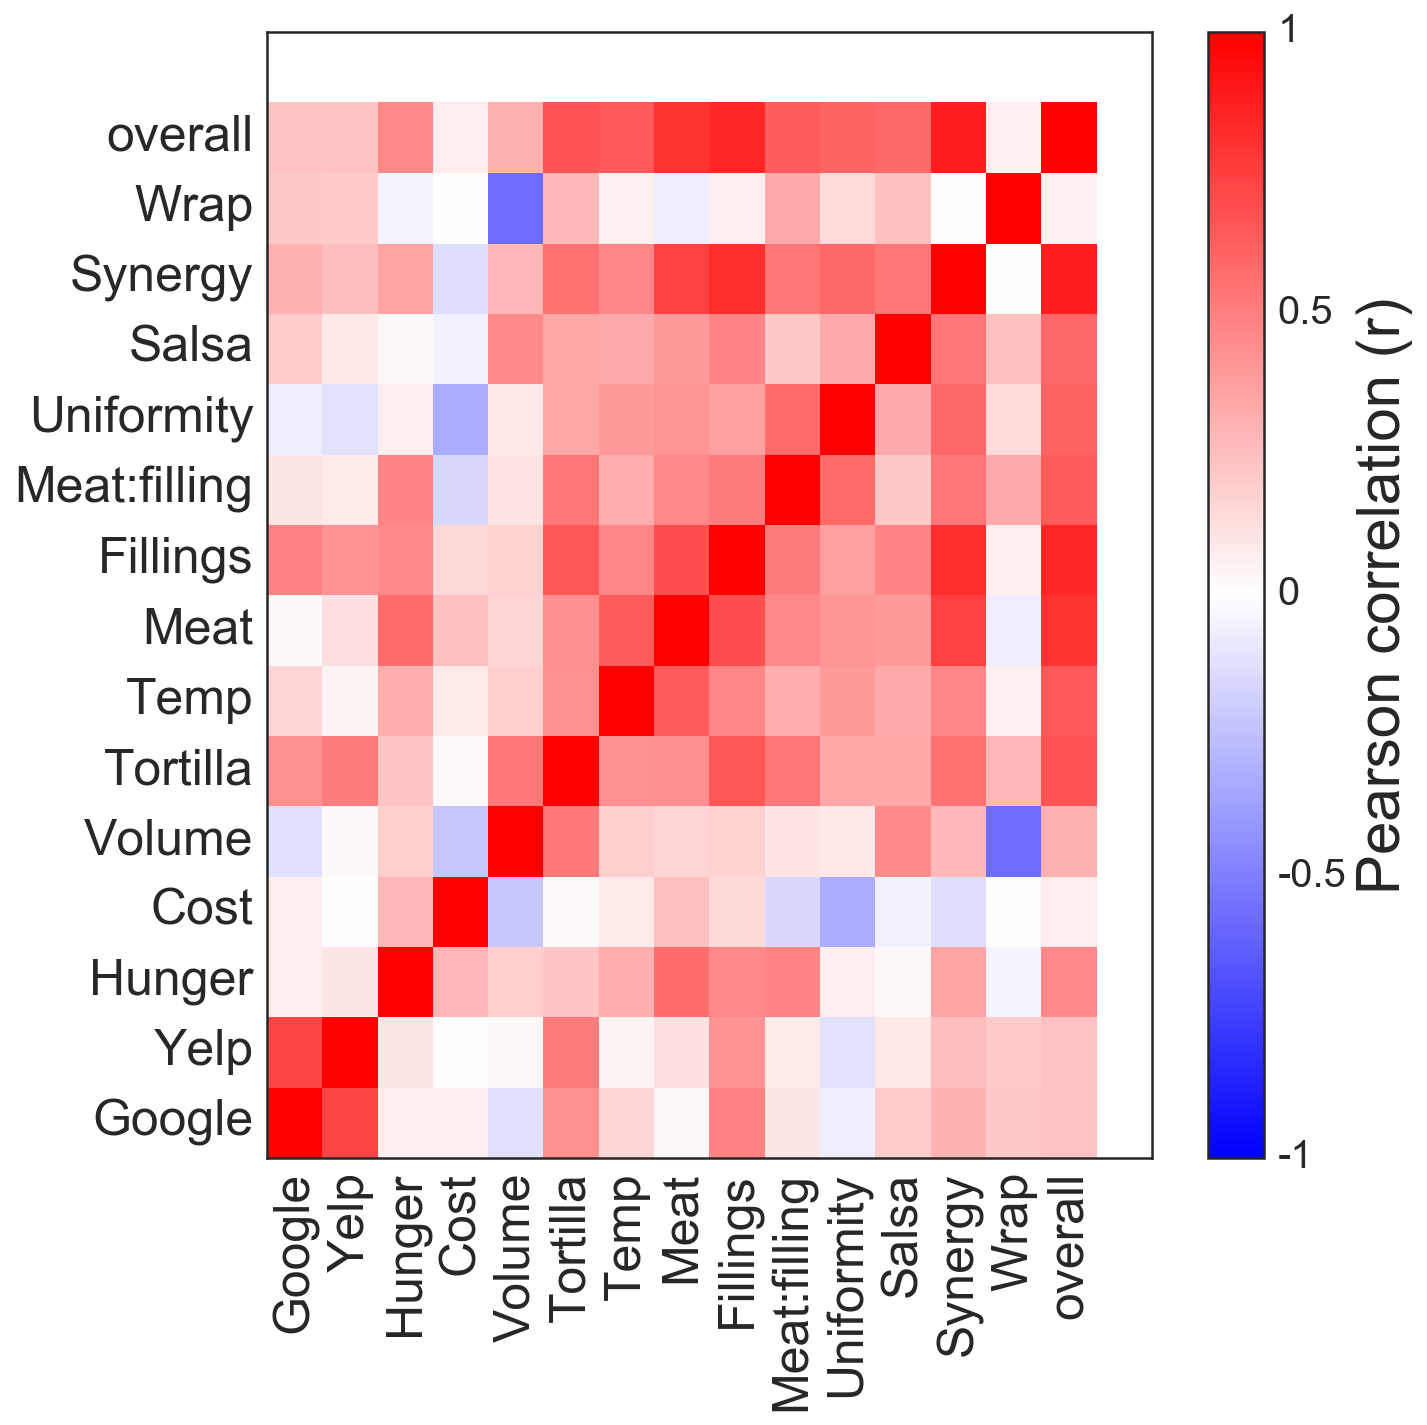

In [9]:
# Note high correlations between features
m_Yelp = ['Google','Yelp','Hunger','Cost','Volume','Tortilla','Temp','Meat','Fillings','Meat:filling',
               'Uniformity','Salsa','Synergy','Wrap','overall']
M = len(m_Yelp)
dfmeancorr = dfmean[m_Yelp].corr()

from matplotlib import cm
clim1 = (-1,1)
plt.figure(figsize=(10,10))
cax = plt.pcolor(range(M+1), range(M+1), dfmeancorr, cmap=cm.bwr)
cbar = plt.colorbar(cax, ticks=(-1,-.5,0,.5,1))
cbar.ax.set_ylabel('Pearson correlation (r)', size=30)
plt.clim(clim1)
cbar.ax.set_yticklabels((-1,-.5,0,.5,1),size=20)
ax = plt.gca()
ax.set_yticks(np.arange(M)+.5)
ax.set_yticklabels(m_Yelp,size=25)
ax.set_xticks(np.arange(M)+.5)
ax.set_xticklabels(m_Yelp,size=25)
plt.xticks(rotation='vertical')
plt.tight_layout()

In [10]:
# GLM for Yelp: all dimensions
m_Yelp = ['Hunger','Cost','Tortilla','Temp','Meat','Fillings','Meat:filling',
               'Uniformity','Salsa','Synergy','Wrap','overall']
dffull = dfmean[np.hstack((m_Yelp,'Yelp'))].dropna()
X = sm.add_constant(dffull[m_Yelp])
y = dffull['Yelp']
my_glm = sm.GLM(y,X)
res = my_glm.fit()
print(res.summary())
print(res.pvalues)
print 1 - np.var(res.resid_pearson) / np.var(y)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Yelp   No. Observations:                   28
Model:                            GLM   Df Residuals:                       15
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                  0.199135164543
Method:                          IRLS   Log-Likelihood:                -8.3993
Date:                Sat, 21 May 2016   Deviance:                       2.9870
Time:                        16:25:00   Pearson chi2:                     2.99
No. Iterations:                     4                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            3.5667      1.317      2.708      0.007         0.986     6.148
Hunger          -0.0374      0.266     -0.140 

In [11]:
# GLM for Yelp: some dimensions
m_Yelp = ['Tortilla','overall']
dffull = dfmean[np.hstack((m_Yelp,'Yelp'))].dropna()
X = sm.add_constant(dffull[m_Yelp])
y = dffull['Yelp']
my_glm = sm.GLM(y,X)
res = my_glm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Yelp   No. Observations:                   30
Model:                            GLM   Df Residuals:                       27
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                  0.166140611331
Method:                          IRLS   Log-Likelihood:                -14.064
Date:                Sat, 21 May 2016   Deviance:                       4.4858
Time:                        16:25:00   Pearson chi2:                     4.49
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.0931      0.381      8.116      0.000         2.346     3.840
Tortilla       0.3944      0.134      2.940      0.0

SpearmanrResult(correlation=0.51339389759131981, pvalue=0.003713638811261227)


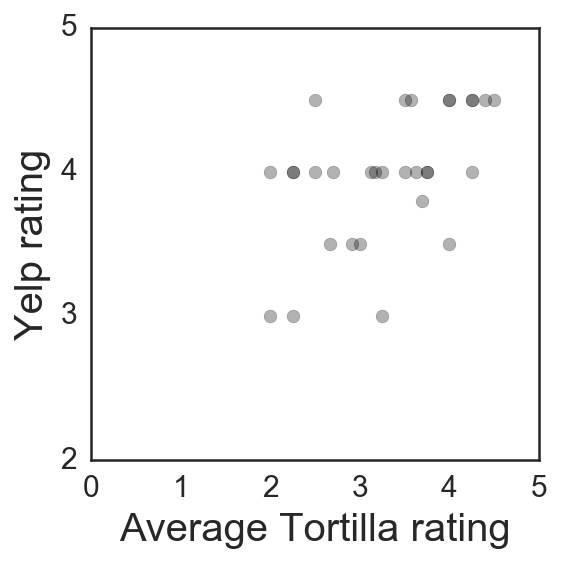

In [13]:
plt.figure(figsize=(4,4))
ax = plt.gca()
dfmean.plot(kind='scatter',x='Tortilla',y='Yelp',ax=ax,**{'s':40,'color':'k','alpha':.3})
plt.xlabel('Average Tortilla rating',size=20)
plt.ylabel('Yelp rating',size=20)
plt.xticks(np.arange(0,6),size=15)
plt.yticks(np.arange(0,6),size=15)
plt.ylim((2,5))
plt.tight_layout()
print sp.stats.spearmanr(dffull.Yelp,dffull.Tortilla)

figname = 'corr-Yelp-tortilla'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')